# Part 1: Exploratory Data Analysis & ML Pipeline
The following exploratory data analysis aims to shed light on a BBC dataset of articles that have been clustered into 5 categories: business, entertainment, politics, sport or tech. Subsequently, an unsupervised machine learning model is built and trained. Later the hyperparameters are tuned in order to improve the model performance. Lastly, the unsupervised approach is compared with a supervised learning model and the results are analyzed. 

## Github Repository
https://github.com/tseidel0509/Unsupervised_ML/blob/main/BBC_Mini_Project.ipynb

## Data Source
The dataset used, is from Kaggle. It consists of 1490 records for training and 735 for testing with 3 columns: ArticleID, Text, and Category. 

Bijoy Bose. BBC News Classification. https://kaggle.com/competitions/learn-ai-bbc, 2019. Kaggle

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import re
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import unicodedata
from sklearn.feature_extraction import text
import nltk
from nltk.corpus import wordnet
from nltk import pos_tag, word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


nltk.download("punkt")
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("averaged_perceptron_tagger")

[nltk_data] Downloading package punkt to /Users/timseidel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/timseidel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/timseidel/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/timseidel/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

#### Import the Dataset

In [61]:
file_path = "/Users/timseidel/Documents/Graduate_Certificate/BBC_MiniProject/learn-ai-bbc/BBC News Train.csv"
df_train = pd.read_csv(file_path)
file_path_test = "/Users/timseidel/Documents/Graduate_Certificate/BBC_MiniProject/learn-ai-bbc/BBC News Test.csv"
df_test = pd.read_csv(file_path_test)
df_train

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business
...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment
1487,1590,weak dollar hits reuters revenues at media gro...,business
1488,1587,apple ipod family expands market apple has exp...,tech


## Step 1: Exploratory Data Analysis

The analysis consists of: 
- Basic Word Statistics
  - Average Character Length & Descriptive Statistics
  - Average Number of Words and Descriptive Statistics
- Word Frequency Analysis
  - All Words
  - Meaningful Words (excl. english stop words)
- Word Cloud
- Boxplot of Articles per Category
- TF-IDF Vectorization + Heatmap
  - TF-IDF across all categories
  - TF-IDF by category

Data Cleaning is part of Step 1 according to the instructions, yet usually I would place it under Data Preprocessing. 

#### 1.1 Basic Word Statistics

In [62]:
char_lengths = df_train["Text"].apply(len)
print("Average Character Length and Descriptive Statistics: ")
print(char_lengths.describe(), "\n")

word_counts = df_train["Text"].apply(lambda x: len(str(x).split()))
print("Average Number of Words and Descriptive Statistics: ")
print(word_counts.describe(), "\n")

Average Character Length and Descriptive Statistics: 
count     1490.000000
mean      2233.461745
std       1205.153358
min        501.000000
25%       1453.000000
50%       1961.000000
75%       2751.250000
max      18387.000000
Name: Text, dtype: float64 

Average Number of Words and Descriptive Statistics: 
count    1490.000000
mean      385.012752
std       210.898616
min        90.000000
25%       253.000000
50%       337.000000
75%       468.750000
max      3345.000000
Name: Text, dtype: float64 



#### 1.2 Word Frequency Analysis

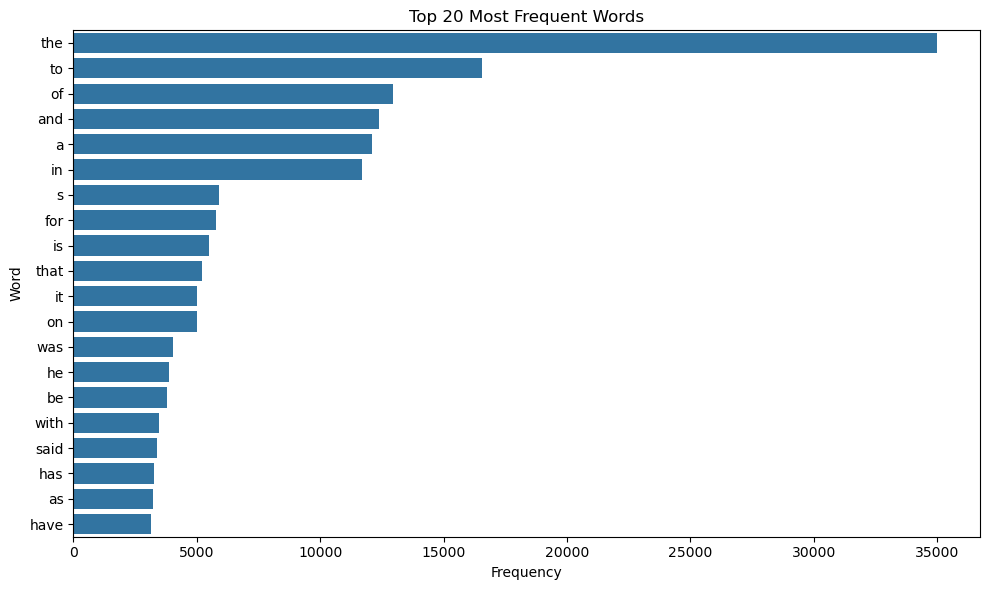

In [63]:
# The following plots the 20 most frequently used words in all articles INCLUDING english stop-words

all_words = " ".join(df_train["Text"]).split()
word_counts = Counter(all_words)

top_words = word_counts.most_common(20)
top_words_df = pd.DataFrame(top_words, columns=["Word", "Frequency"])

plt.figure(figsize=(10,6))
sns.barplot(data=top_words_df, x = "Frequency", y = "Word")
plt.title("Top 20 Most Frequent Words")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.tight_layout()
plt.show()

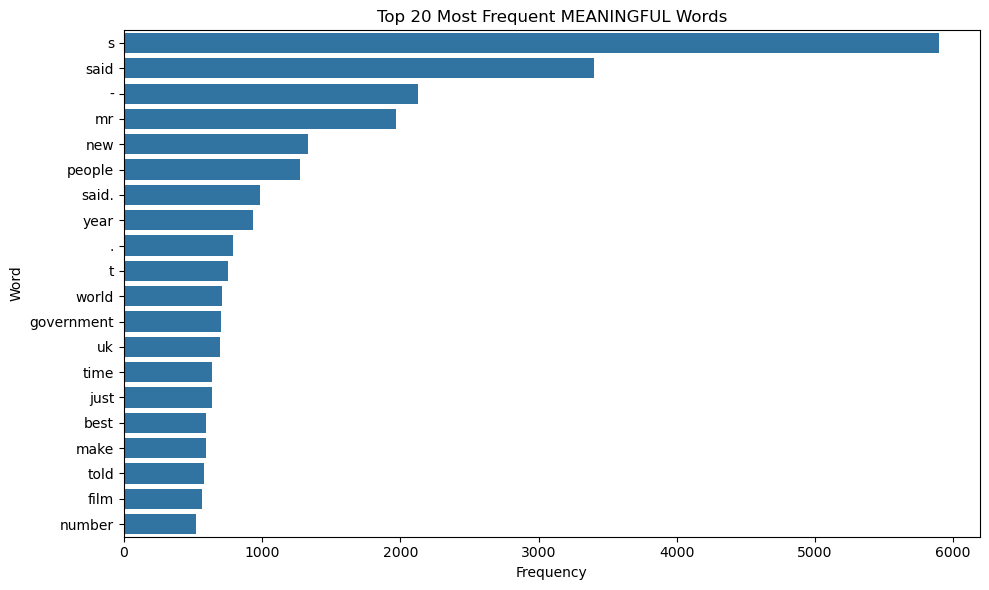

In [64]:
# The following plots the 20 most frequently used words in all articles EXCLUDING english stop-words

stopwords = set(text.ENGLISH_STOP_WORDS)
meaningful_words = [
    word for word in " ".join(df_train["Text"]).split()
    if word not in stopwords
]

meaningful_words_counts = Counter(meaningful_words)
top_meaningful_words_df = pd.DataFrame(meaningful_words_counts.most_common(20), columns=["Word", "Frequency"])

plt.figure(figsize=(10,6))
sns.barplot(data=top_meaningful_words_df, x = "Frequency", y = "Word")
plt.title("Top 20 Most Frequent MEANINGFUL Words")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.tight_layout()
plt.show()

#### 1.3 Word Cloud
The following is a wordcloud of the meaningful words, hence it does not depict english stopwords. 

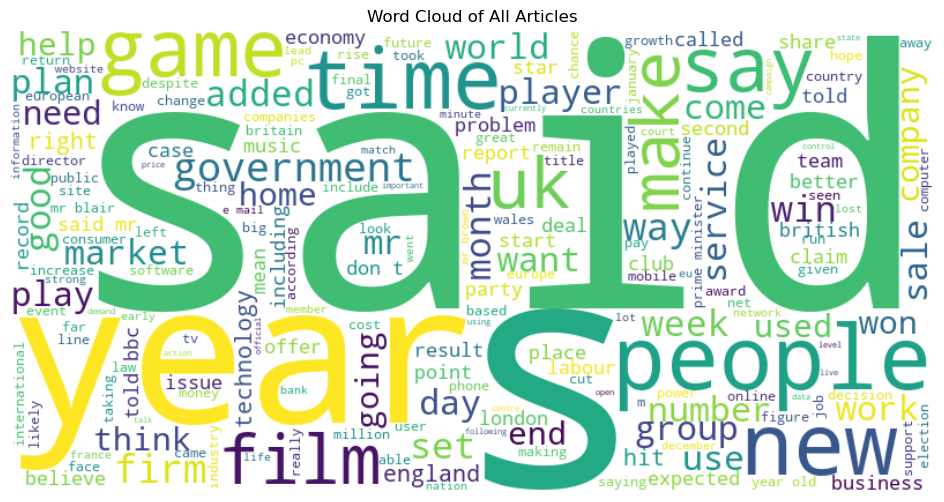

In [65]:
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(meaningful_words))
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of All Articles")
plt.show()

#### 1.4 Boxplot of Articles per Category

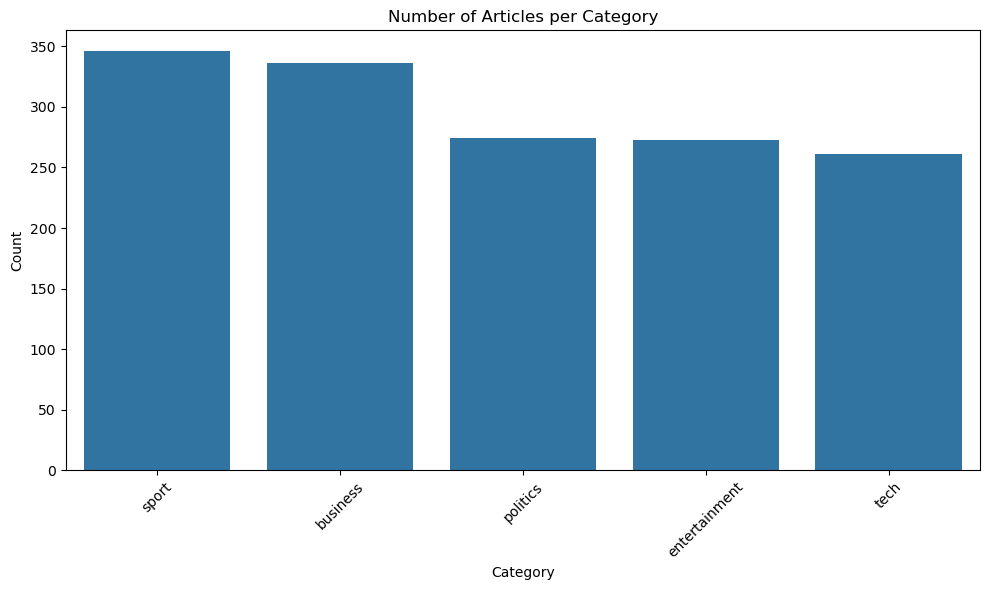

In [66]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_train, x="Category", order=df_train["Category"].value_counts().index)
plt.title("Number of Articles per Category")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### 1.5 TF-IDF Vectorization

#### 1.5.1 Accross all Categories
The following code performes TF-IDF based text feature extraction and then visualizes the importance of the top 20 words across a random sample of 40 articles using a heatmap. A sample was chosen because showing all articles would excessively clutter the plot. Also, I made sure to not include english stop words. 

##### TF-IDF (Term Frequency-Inverse Document Frequency)
It is a way to convert text into meaningful numerical features.
- TF (Term Frequency): measures how often a word appears in a document by counting the word in the document and dividing it by the total number of words in the document
- IDF (Inverse Document Frequency): downweights words that appear in many documents, hence that could be less informative.

As such a high TF-IDF value constitutes a word that is frequent in the specific document but rare across the corpus. 

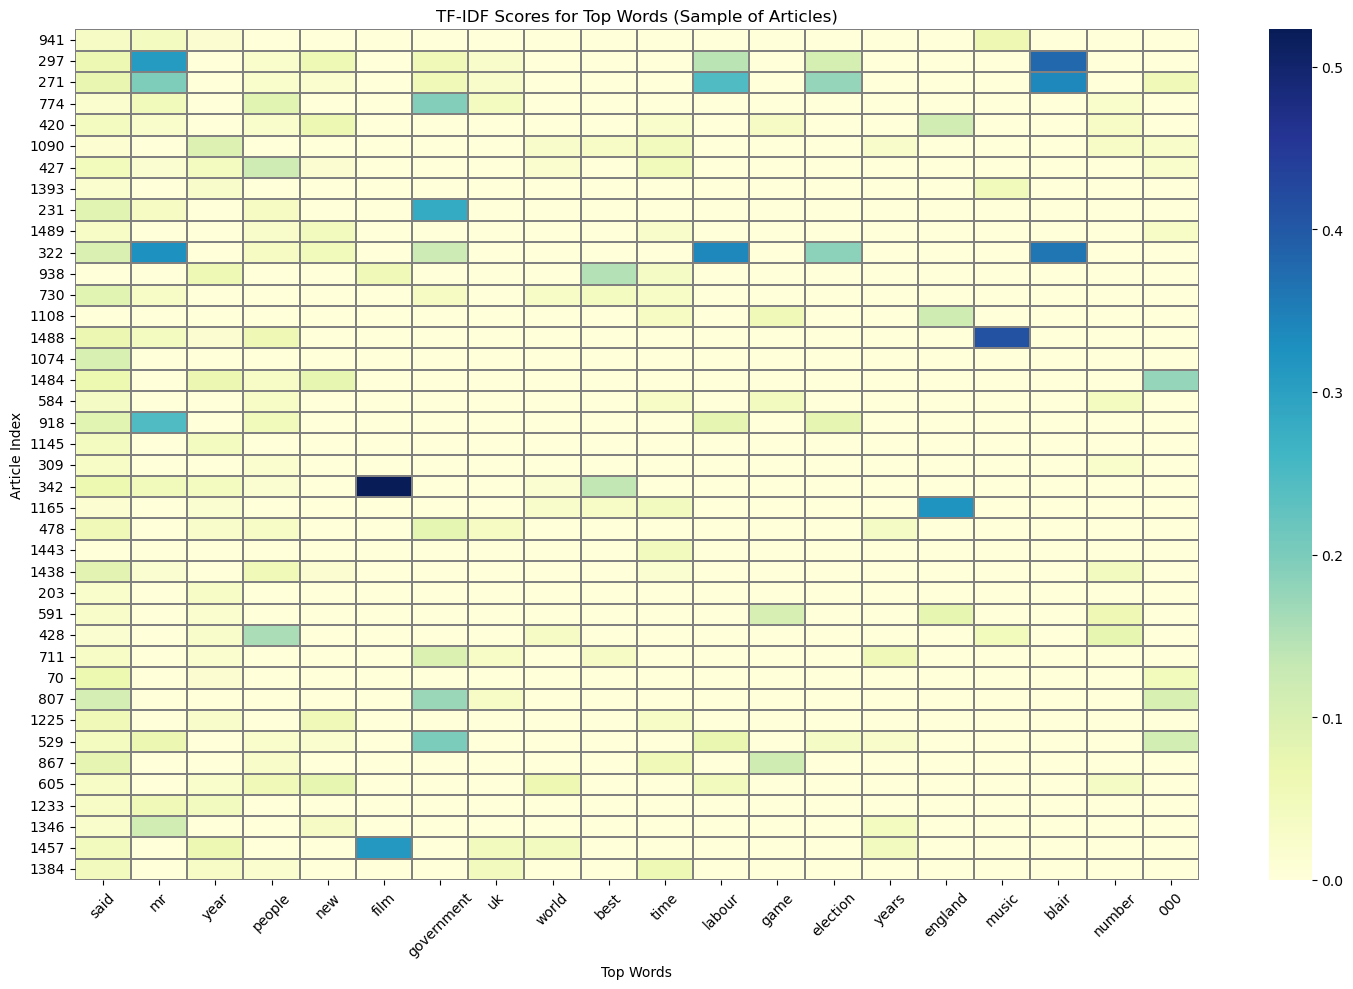

In [67]:
# TF-IDF vectorization
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
tfidf_matrix = vectorizer.fit_transform(df_train["Text"])
feature_names = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# Select top 20 words by mean TF-IDF score
top_tfidf_words = tfidf_df.mean().sort_values(ascending=False).head(20).index

# Take a sample of 40 articles
sample_df = tfidf_df.sample(n=40, random_state=42)

# Heatmap of TF-IDF Scores for Top Words
plt.figure(figsize=(15, 10))
sns.heatmap(sample_df[top_tfidf_words], annot=False, cmap="YlGnBu", linewidths=0.2, linecolor='gray')
plt.title("TF-IDF Scores for Top Words (Sample of Articles)")
plt.xlabel("Top Words")
plt.ylabel("Article Index")
plt.xticks(rotation=45)
plt.tight_layout()

#### 1.5.2 TF-IDF Vectorization - By Category 
Thereby words are ranked only within their own "group". This prevents words from being overshadowed by high-frequency terms in other categories. 


 Category: business


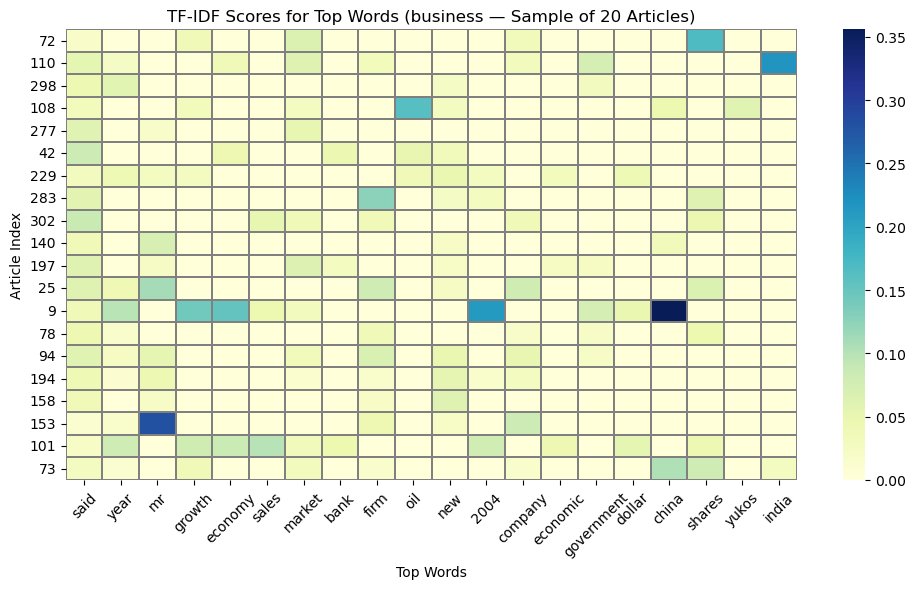


 Category: tech


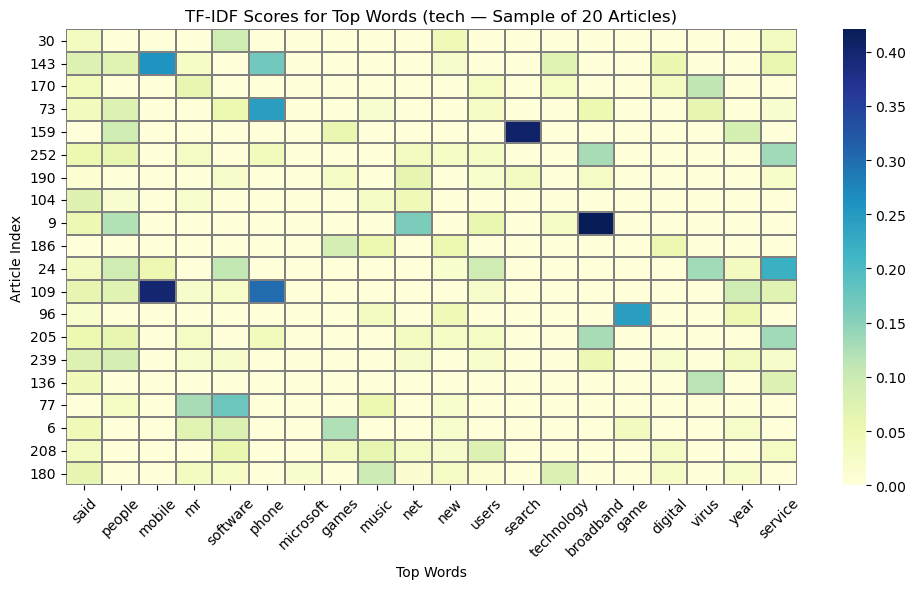


 Category: politics


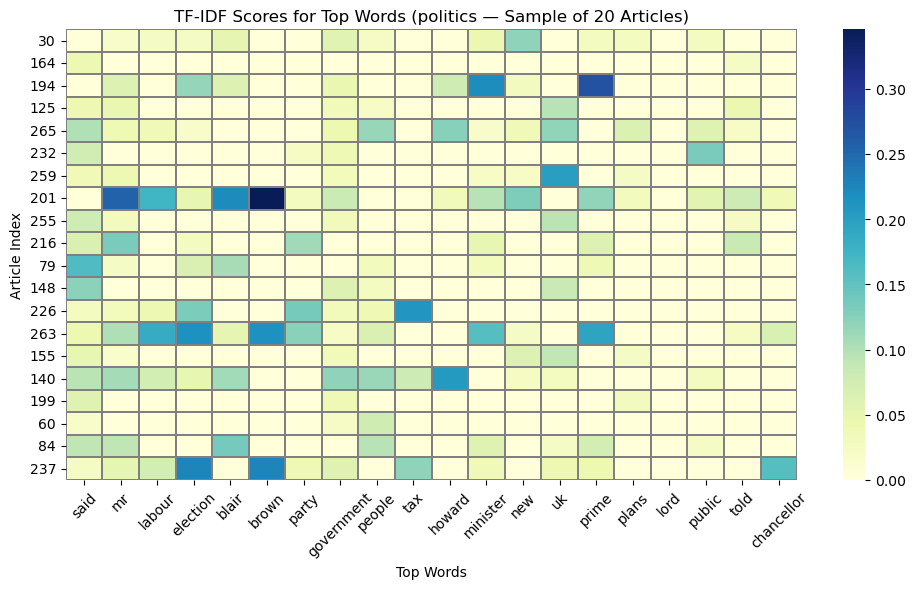


 Category: sport


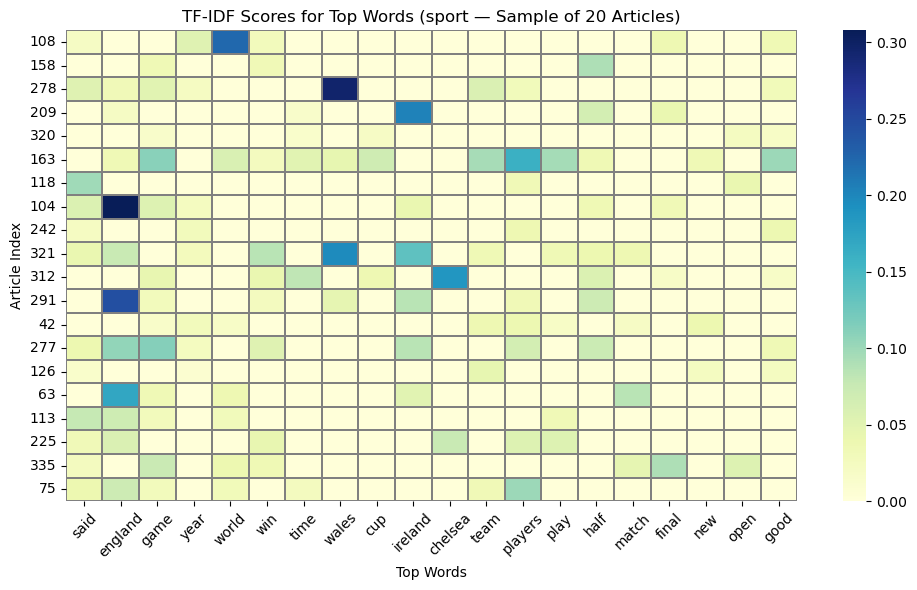


 Category: entertainment


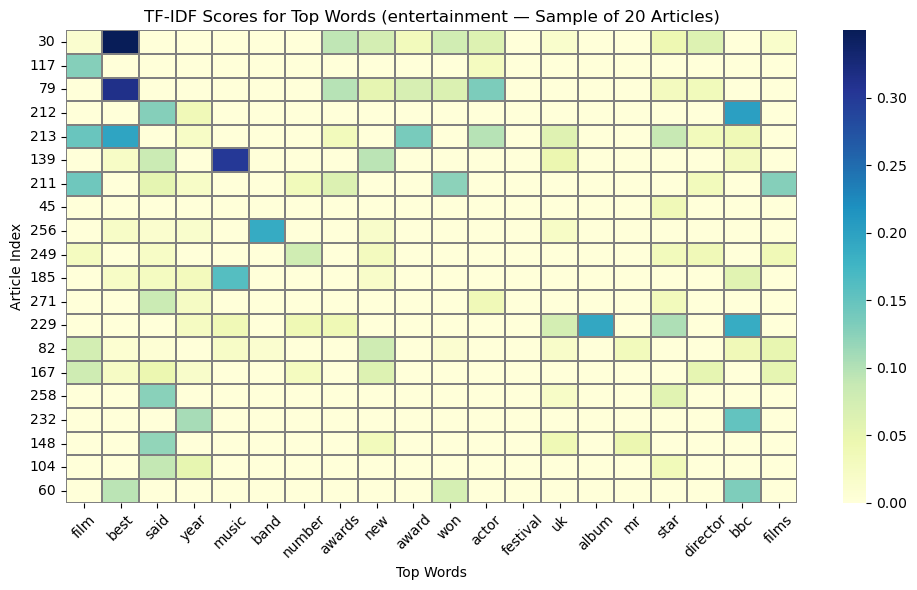

In [68]:
categories = df_train["Category"].unique()

for category in categories:
    print(f"\n Category: {category}")
    
    category_df = df_train[df_train["Category"] == category]

    # TF-IDF vectorization for this category only
    vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
    tfidf_matrix = vectorizer.fit_transform(category_df["Text"])
    feature_names = vectorizer.get_feature_names_out()
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

    # Select top 20 words by mean TF-IDF score
    top_tfidf_words = tfidf_df.mean().sort_values(ascending=False).head(20).index

    # Sample up to 40 articles for the heatmap
    sample_n = 20
    sample_df = tfidf_df.sample(n=sample_n, random_state=42)

    # Plot the heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(sample_df[top_tfidf_words], annot=False, cmap="YlGnBu", linewidths=0.2, linecolor='gray')
    plt.title(f"TF-IDF Scores for Top Words ({category} — Sample of {sample_n} Articles)")
    plt.xlabel("Top Words")
    plt.ylabel("Article Index")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

The Exploratory Analysis has shown, that each category of article has its own set of most important words. There exist clear differences between each category and merely by visual inspection one can identify broad topics within each category. For example: political articles likely revolve around UK politics and the election as well as Tony Blair (the then prime minister) of the labour party. Potentially uses of the word Chancellor refer to the German Chancellor. Hence, these clear differences in the top words per category indicate that an unsupervised model is likely be able to learn the latent features that indicate a cluster. 

## Data Preprocessing

### Data Cleaning

It is important to clean the data in order to ensure consistency and reliability when analyzing text data.  

The following steps are performed: 
- Convertion to lowercase for case insensitivity: reduces the number of unique tokens, thereby it can improve model focus 
- Normalize to NFKD to decompose characters: ensures consistency when dealing with accented or composed characters
- Removal of punctuation: 
- Normalization of whitespace: to prevent irregular spacing from affecting tokenization
- Lemmatization: this is the process of reducing words to their base or dictionary form called a lemma. Unlike stemming (which simply chops off suffixes), lemmatization uses linguistic knowledge to return real words. 

Each step reduces noise, improves the consistency of the text and ensures better downstream modeling. The cleaned text shall be used when training the models. 


In [69]:
lemmatizer = WordNetLemmatizer()
def get_wordnet_pos(tag):
    if tag.startswith("J"):
        return wordnet.ADJ
    elif tag.startswith("V"):
        return wordnet.VERB
    elif tag.startswith("N"):
        return wordnet.NOUN
    elif tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN


def clean_text(text):
    # Lowercase
    text = str(text).lower()

    # Unicode normalization to NFKD
    text = unicodedata.normalize('NFKD', text)

    # Remove combining characters (accents, etc.)
    text = ''.join([c for c in text if not unicodedata.combining(c)])

    # Keep letters, numbers, and spaces
    text = re.sub(r'[^a-z0-9\s]', '', text)

    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Lemmatization
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    lemmatized = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tags]
    return " ".join(lemmatized)

    return text

df_train["CleanedTrain"] = df_train["Text"].apply(clean_text)
df_test["CleanedTest"] = df_test["Text"].apply(clean_text)

len_df_train = len(df_train)
len_df_test = len(df_test)
print(f"Train set size: {len_df_train}")
print(f"Train set size: {len_df_test}")
df_train.head()


Train set size: 1490
Train set size: 735


,ArticleId,Text,Category,CleanedTrain
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom exboss launch defence lawyer defend f...
1,154,german business confidence slides german busin...,business,german business confidence slides german busin...
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicate economic gloom citizen in a ...
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster well or...
4,917,enron bosses in $168m payout eighteen former e...,business,enron boss in 168m payout eighteen former enro...


#### Remove Duplicates

In [70]:
# Drop duplicates based on ArticleID
df_train = df_train.drop_duplicates(subset=["ArticleId"])

# Drop duplicates based on Text Content
df_train = df_train.drop_duplicates(subset=["Text"])

# Reset Index
df_train.reset_index(drop=True, inplace = True)

len_df_train_noduplicates = len(df_train)
print(f"Number of removed training duplicates: {len_df_train - len_df_train_noduplicates}")

Number of removed training duplicates: 50


## Step 2: Building, Training, and Evaluating the Models
Question: Should you include texts (word features) from the test dataset or not as the input matrix? Why or why not?

Answer: No, this would break the isolation of the test set, because the model would then learn patterns from the test set which would benefit its prediction capabilities on the test set. 

### 2.1 Building / Training NMF Model
- An NMF model is trained on TF-IDF features from CleanedTrain, excluding the column category
  - Each document is then assigned to its most dominant topic, i.e. the index of the topic with the highest weight is chosen as the dominant article type. This is necessary, because NMF returns a soft assignment -> hence, each article can be a mix of topics.
  - Subsequently, majority vote is used to map the discovered topics to their true categorical values (categories)
    - Ex. assume 5 articles were assigned the category 2, the true labels are business and tech but the 3 out of 5 (the majority) are labeled as business, then all articles are labeled as business.

In [71]:
# TF-IDF Vectorization ´
vectorizer = TfidfVectorizer(max_features=1000, stop_words="english")
X_train_tfidf = vectorizer.fit_transform(df_train["CleanedTrain"])
# The vectorizer is not refitted to ensure that the trained vectorizer is applied. 
X_test_tfidf = vectorizer.transform(df_test["CleanedTest"])

# Train NMF Model
nmf_model = NMF(n_components=5, random_state=42)
train_weights_nmf = nmf_model.fit_transform(X_train_tfidf)
# Again the NMF model is not refitted to ensure that the trained NMF model is applied
test_weights_nmf = nmf_model.transform(X_test_tfidf)

# Assign dominant topic to each articles
df_train["AssignedTopic_NMF"] = np.argmax(train_weights_nmf, axis = 1)
df_test["AssignedTopic_NMF"] = np.argmax(test_weights_nmf, axis = 1)

# Map topics to categories using majority voting
topic_to_category = (
    df_train.groupby("AssignedTopic_NMF")["Category"]
    .agg(lambda x: x.value_counts().idxmax())
    .to_dict()
)

df_train["PredictedCategory_NMF"] = df_train["AssignedTopic_NMF"].map(topic_to_category)
df_test["PredictedCategory_NMF"] = df_test["AssignedTopic_NMF"].map(topic_to_category)

### 2.2 Building / Training LSA Model using TruncatedSVD
The procedure used above for NMF is applied equally to the LSA model. 

In [72]:
# Train LSA using TruncatedSVD
lsa_model = TruncatedSVD(n_components = 5, random_state = 42)
train_weights_lsa = lsa_model.fit_transform(X_train_tfidf)
test_weights_lsa = lsa_model.transform(X_test_tfidf)

# Assign Dominant topic to each article
df_train["AssignedTopic_LSA"] = np.argmax(train_weights_lsa, axis = 1)
df_test["AssignedTopic_LSA"] = np.argmax(test_weights_lsa, axis = 1)

# Map topics to categories using majority voting
topic_to_category = (
    df_train.groupby("AssignedTopic_LSA")["Category"]
    .agg(lambda x: x.value_counts().idxmax())
    .to_dict()
)

df_train["PredictedCategory_LSA"] = df_train["AssignedTopic_LSA"].map(topic_to_category)
df_test["PredictedCategory_LSA"] = df_test["AssignedTopic_LSA"].map(topic_to_category)

### 2.3 Evaluating the Models on Train

#### 2.3.1 NMF Evaluation

NMF Train Accuracy:  0.8895833333333333


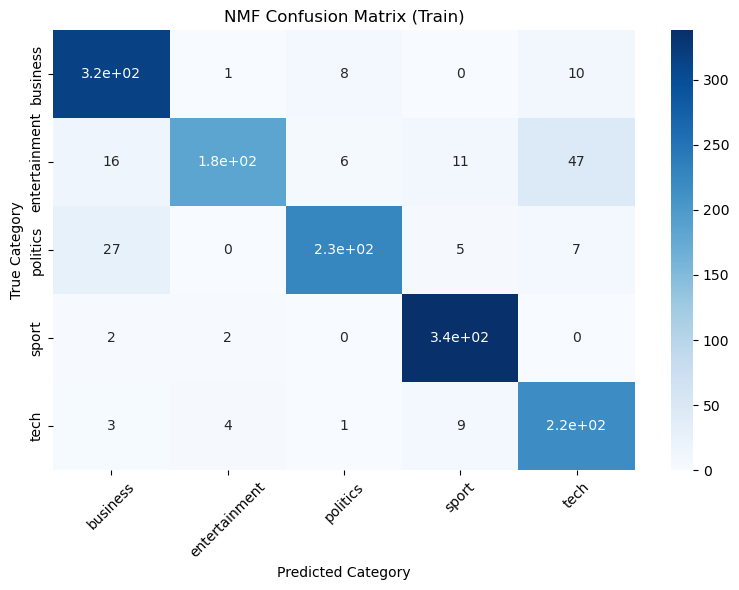

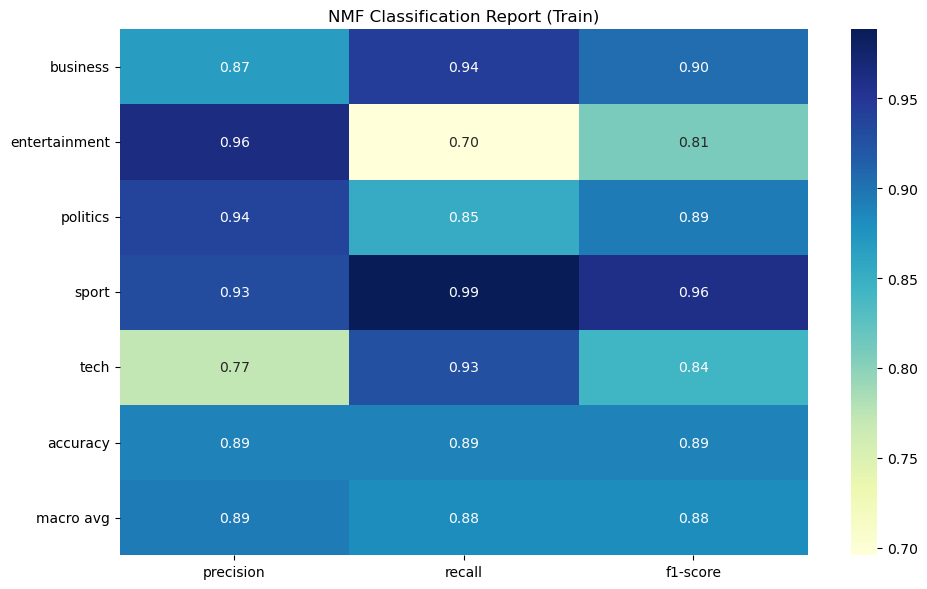

In [73]:
# Evaluate on Training Data
train_accuracy_nmf = accuracy_score(df_train["Category"], df_train["PredictedCategory_NMF"])
print("NMF Train Accuracy: ", train_accuracy_nmf)

# Confusion Matrix
cm = confusion_matrix(df_train["Category"], df_train["PredictedCategory_NMF"])
labels = sorted(df_train["Category"].unique())

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot = True, xticklabels = labels, cmap = "Blues", yticklabels = labels)
plt.title("NMF Confusion Matrix (Train)")
plt.xlabel("Predicted Category")
plt.ylabel("True Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Classification Report
report = classification_report(df_train["Category"], df_train["PredictedCategory_NMF"], output_dict = True)
report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(10,6))
sns.heatmap(report_df.iloc[:-1, :-1], annot = True, cmap="YlGnBu", fmt=".2f")
plt.title("NMF Classification Report (Train)")
plt.tight_layout()
plt.show()


#### 2.3.2 LSA Evaluation

LSA Train Accuracy:  0.3875


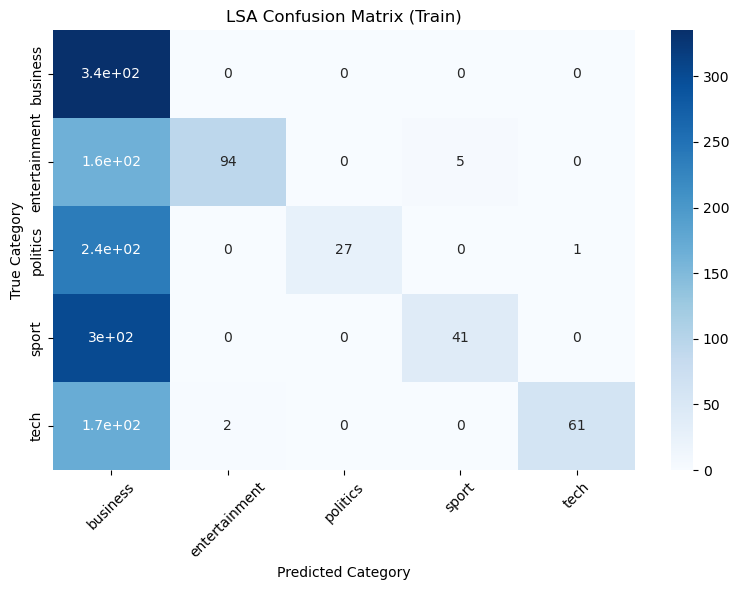

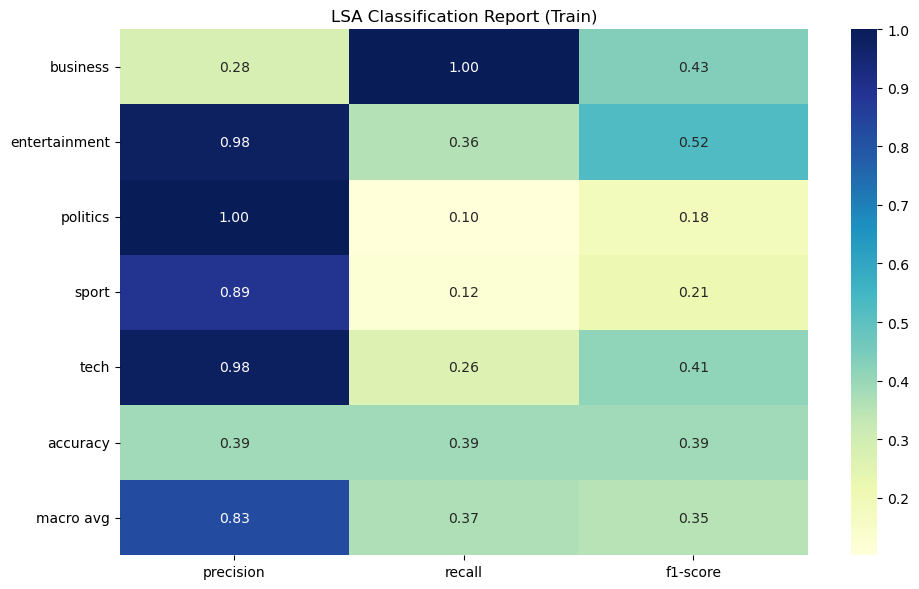

In [74]:
# Evaluate on Training Data
train_accuracy_lsa = accuracy_score(df_train["Category"], df_train["PredictedCategory_LSA"])
print("LSA Train Accuracy: ", train_accuracy_lsa)

# Confusion Matrix
cm = confusion_matrix(df_train["Category"], df_train["PredictedCategory_LSA"])
labels = sorted(df_train["Category"].unique())

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot = True, xticklabels = labels, cmap = "Blues", yticklabels = labels)
plt.title("LSA Confusion Matrix (Train)")
plt.xlabel("Predicted Category")
plt.ylabel("True Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Classification Report
report = classification_report(df_train["Category"], df_train["PredictedCategory_LSA"], output_dict = True)
report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(10,6))
sns.heatmap(report_df.iloc[:-1, :-1], annot = True, cmap="YlGnBu", fmt=".2f")
plt.title("LSA Classification Report (Train)")
plt.tight_layout()
plt.show()

### 2.4 Evaluate NMF on Test via Kaggle
In order to upload to Kaggle, the format of the sample solution shall be used. Relevant columns include the ArticleID and the PredictedCategory_NMF. The datafram shall be exported to csv. Given that the LSA approach returned poor results solely NMF shall be used.

In [75]:
# Create a dataframe similar to the sample solution in order to upload to Kaggle
df_test_nmf = df_test[["ArticleId", "PredictedCategory_NMF"]].copy()
df_test_nmf = df_test_nmf.rename(columns={"PredictedCategory_NMF": "Category"})

# Export to csv
df_test_nmf.to_csv("nmf_test_predictions.csv", index=False)
df_test_nmf

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport
...,...,...
730,1923,business
731,373,entertainment
732,1704,tech
733,206,business


After uploading to Kaggle, I recevied the following score on my test set. 

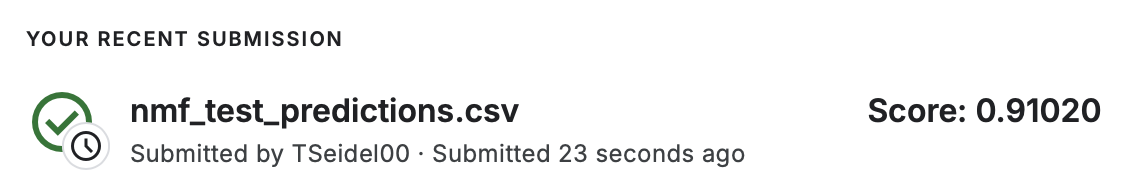

In case, the image does not load -> 0.91020 i.e. 91.02% accuracy on the test set

### 2.5 Change Hyperparameter n_components and Re-Evaluate
The following code evaluates multiple values for the hyperparameter n_components in order to identify the model with the highest accuracy score on train. Subsequently, NMF is retrained with that value for n_components and a prediction on the test set is performed. It is then evaluated by creating a dataframe according to the sample solution and uploading it to kaggle once again. 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


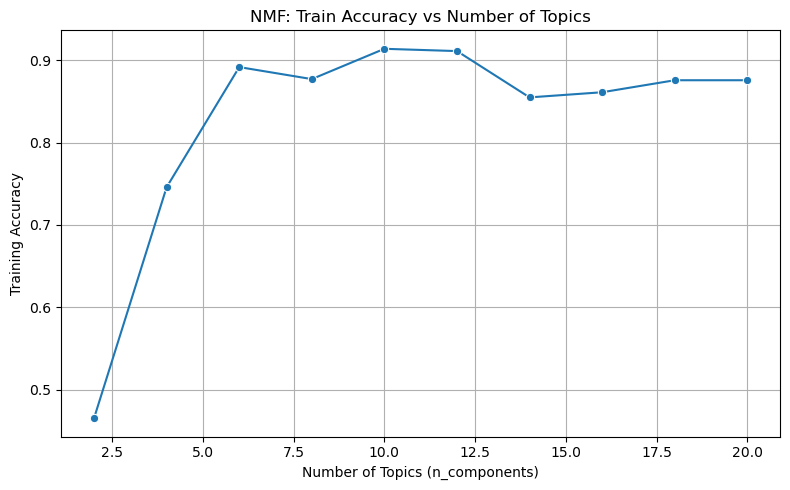

Best n_components based on train accuracy: 10.0
Retraining with best value for n_components: 10.0


/opt/anaconda3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [76]:
results = []
for n_topics in range(2, 21, 2):
    nmf_model = NMF(n_components = n_topics, random_state=42)
    train_weights = nmf_model.fit_transform(X_train_tfidf)
    df_train["AssignedTopic_NMF_Improve"] = np.argmax(train_weights, axis = 1)
    topic_to_category = (
        df_train.groupby("AssignedTopic_NMF_Improve")["Category"]
        .agg(lambda x: x.value_counts().idxmax())
        .to_dict()
    )
    df_train["PredictedCategory_NMF_Improve"] = df_train["AssignedTopic_NMF_Improve"].map(topic_to_category)
    acc = accuracy_score(df_train["Category"], df_train["PredictedCategory_NMF_Improve"])
    results.append({"n_topics": n_topics, "train_accuracy": acc})

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Plot accuracy vs. number of topics
plt.figure(figsize=(8, 5))
sns.lineplot(data=results_df, x="n_topics", y="train_accuracy", marker="o")
plt.title("NMF: Train Accuracy vs Number of Topics")
plt.xlabel("Number of Topics (n_components)")
plt.ylabel("Training Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()

# Get best number of components
best_n = results_df.sort_values(by="train_accuracy", ascending=False).iloc[0]["n_topics"]
print(f"Best n_components based on train accuracy: {best_n}")

print(f"Retraining with best value for n_components: {best_n}")

# Retrain with best n_components
best_nmf = NMF(n_components=int(best_n), random_state = 42)
train_weight_best = best_nmf.fit_transform(X_train_tfidf)
test_weight_best = best_nmf.transform(X_test_tfidf)

# Assign Dominant topic
df_train["AssignedTopic_NMF_Improve"] = np.argmax(train_weight_best, axis = 1)
df_test["AssignedTopic_NMF_Improve"] = np.argmax(test_weight_best, axis = 1)

# Majority vote
topic_to_category = (
    df_train.groupby("AssignedTopic_NMF_Improve")["Category"]
    .agg(lambda x: x.value_counts().idxmax())
    .to_dict()
)

df_test["PredictedCategory_NMF_Improve_Test"] = df_test["AssignedTopic_NMF_Improve"].map(topic_to_category)

# Create Dataframe
df_test_nmf_best = df_test[["ArticleId", "PredictedCategory_NMF_Improve_Test"]].copy()
df_test_nmf_best.rename(columns={"PredictedCategory_NMF_Improve_Test": "Category"}, inplace=True)

df_test_nmf_best.to_csv("df_test_nmf_best.csv", index=False)

After uploading to Kaggle, I recevied the following score on my test set. 

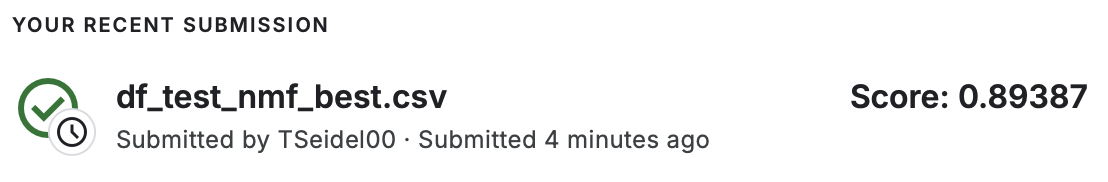

In case, the image does not load -> 0.89387 i.e. 89.39% accuracy on the test set. This goes to show that the model may well have started to overfit on the training data and has become less proficient in generalizing to new data.

### 2.6 Improve Model Performance 
The following changes are applied: 
- Step 1: Use Bigrams and Unigrams in TF-IDF: this allows the model to capture context like "prime minister" from the "prime" and "minister"
- Step 2: Ensembling voting from multiple NMF Models: multiple NMF models with different random_states are combined via majority voting over the assigned topics in order to yield the final topic

In [77]:
# TF-IDF Vectorization with bigrams and unigrams
vectorizer = TfidfVectorizer(
    max_features=2000,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=3
)
X_train_tfidf = vectorizer.fit_transform(df_train["CleanedTrain"])
X_test_tfidf = vectorizer.transform(df_test["CleanedTest"])

n_components = 5
n_models = 5

all_train_predictions = []
all_test_predictions = []

for seed in range(n_models):
    nmf_model = NMF(n_components=n_components, random_state=seed)
    W_train = nmf_model.fit_transform(X_train_tfidf)
    W_test = nmf_model.transform(X_test_tfidf)

    # Assign dominant topic to new column
    df_train["AssignedTopic_Hyper"] = np.argmax(W_train, axis=1)
    df_test["AssignedTopic_Hyper"] = np.argmax(W_test, axis=1)

    # Majority vote mapping
    topic_to_category = (
        df_train.groupby("AssignedTopic_Hyper")["Category"]
        .agg(lambda x: x.value_counts().idxmax())
        .to_dict()
    )

    # Map predictions
    train_pred = df_train["AssignedTopic_Hyper"].map(topic_to_category)
    test_pred = df_test["AssignedTopic_Hyper"].map(topic_to_category)

    all_train_predictions.append(train_pred.tolist())
    all_test_predictions.append(test_pred.tolist())

# Final ensemble prediction (train)
ensemble_train_preds = []
for i in range(len(df_train)):
    votes = [preds[i] for preds in all_train_predictions if preds[i] is not np.nan]
    if votes:
        ensemble_train_preds.append(Counter(votes).most_common(1)[0][0])
    else:
        ensemble_train_preds.append("unknown")

# Final ensemble prediction (test)
ensemble_test_preds = []
for i in range(len(df_test)):
    votes = [preds[i] for preds in all_test_predictions if preds[i] is not np.nan]
    if votes:
        ensemble_test_preds.append(Counter(votes).most_common(1)[0][0])
    else:
        ensemble_test_preds.append("unknown")

# Evaluate training accuracy
train_accuracy = accuracy_score(df_train["Category"], ensemble_train_preds)
print(f"Ensemble NMF Train Accuracy (Improved): {train_accuracy:.4f}")

# Create and export test result DataFrame
df_test_nmf_ensemble = df_test[["ArticleId"]].copy()
df_test_nmf_ensemble["Category"] = ensemble_test_preds
df_test_nmf_ensemble.to_csv("nmf_ensemble_test_predictions.csv", index=False)

Ensemble NMF Train Accuracy (Improved): 0.9035


After uploading to Kaggle, I recevied the following score on my test set. 

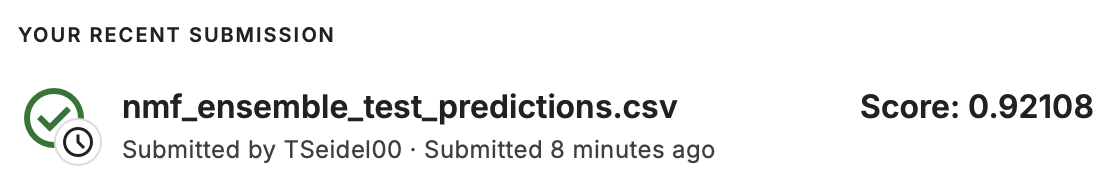

In case, the image does not load -> 0.92108 i.e. 92.11% accuracy on the test set. This goes to show that using bigrams and unigrams in TF-IDF and Ensembling the voting from multiple NMF Models improved the performance on train and test.  

## Step 3: Comparing NMF with Supervised Learning
#### 2 Supervised Models: Logistic Regression and Random Forest

In the following code, I use Logistic Regression and Random Forest as supervised learning models. Specifically I, performed TF-IDF with unigrams and bigrams, used the "Category" columns as the true label and then returned accuracy on df_train and predictions on ddf_test which I then uploaded to kaggle. 

- A train / val split needs to be performed on the training data in order to evaluate on the training data and to be able to compare results for both approach on both training and testing data sets. 

In [78]:
TEST_SIZES = [0.025, 0.05, 0.1, 0.2, 0.5, 0.9]   # fraction of df_train for validation
RANDOM_STATE = 42
# Vectoriser params
VECTOR_PARAMS = dict(
    max_features=2000,
    stop_words="english",
    ngram_range=(1, 2),
    min_df=3,
)

# Supervised models 
LR_PARAMS = dict(max_iter=1000, random_state=RANDOM_STATE)
RF_PARAMS = dict(n_estimators=100, max_depth=25, n_jobs=-1, random_state=RANDOM_STATE)

# NMF ensemble params
NMF_COMPONENTS = 5
NMF_ENS_SIZE  = 5
NMF_PARAMS = dict(n_components=NMF_COMPONENTS, init="nndsvd")

def _majority_vote(list_of_pred_lists):
    ensemble = []
    for row in zip(*list_of_pred_lists):
        valid_votes = [v for v in row if v != "unknown" and pd.notna(v)]
        if valid_votes:
            ensemble.append(Counter(valid_votes).most_common(1)[0][0])
        else:
            ensemble.append("unknown")
    return ensemble


def run_models(train_df: pd.DataFrame, val_df: pd.DataFrame, test_df: pd.DataFrame):
    # Train LR, RF and NMF ensemble; return accuracy metrics and test preds

    # Vectorise text
    vectoriser = TfidfVectorizer(**VECTOR_PARAMS)
    X_train = vectoriser.fit_transform(train_df["CleanedTrain"])
    X_val   = vectoriser.transform(val_df["CleanedTrain"])
    X_test  = vectoriser.transform(test_df["CleanedTest"])

    y_train = train_df["Category"]
    y_val   = val_df["Category"]

    # Logistic Regression
    lr = LogisticRegression(**LR_PARAMS).fit(X_train, y_train)
    lr_train_acc = accuracy_score(y_train, lr.predict(X_train))
    lr_val_acc   = accuracy_score(y_val,   lr.predict(X_val))

    # Random Forest
    rf = RandomForestClassifier(**RF_PARAMS).fit(X_train, y_train)
    rf_train_acc = accuracy_score(y_train, rf.predict(X_train))
    rf_val_acc   = accuracy_score(y_val,   rf.predict(X_val))

    # NMF ensemble
    nmf_train_preds_all, nmf_val_preds_all, nmf_test_preds_all = [], [], []

    for seed in range(NMF_ENS_SIZE):
        nmf = NMF(**NMF_PARAMS, random_state=RANDOM_STATE + seed)
        W_train = nmf.fit_transform(X_train)
        W_val   = nmf.transform(X_val)
        W_test  = nmf.transform(X_test)

        # Dominant topic per sample
        topic_train = W_train.argmax(axis=1)
        topic_val   = W_val.argmax(axis=1)
        topic_test  = W_test.argmax(axis=1)

        mapping = (
            pd.Series(y_train).groupby(topic_train)
            .agg(lambda x: x.value_counts().idxmax())
            .to_dict()
        )

        nmf_train_preds_all.append([mapping.get(t, "unknown") for t in topic_train])
        nmf_val_preds_all.append([mapping.get(t, "unknown") for t in topic_val])
        nmf_test_preds_all.append([mapping.get(t, "unknown") for t in topic_test])

    nmf_train_ens = _majority_vote(nmf_train_preds_all)
    nmf_val_ens   = _majority_vote(nmf_val_preds_all)
    nmf_test_ens  = _majority_vote(nmf_test_preds_all)

    nmf_train_acc = accuracy_score(y_train, nmf_train_ens)
    nmf_val_acc   = accuracy_score(y_val,   nmf_val_ens)

    return {
        # Accuracies
        "lr_train_acc":  lr_train_acc,
        "lr_val_acc":    lr_val_acc,
        "rf_train_acc":  rf_train_acc,
        "rf_val_acc":    rf_val_acc,
        "nmf_train_acc": nmf_train_acc,
        "nmf_val_acc":   nmf_val_acc,

        # Test predictions
        "lr_test_pred":  lr.predict(X_test),
        "rf_test_pred":  rf.predict(X_test),
        "nmf_test_pred": nmf_test_ens,
    }

# Experiment – vary validation fraction

valsize_results = []
for size in TEST_SIZES:
    train_split, val_split = train_test_split(
        df_train,
        test_size=size,
        stratify=df_train["Category"],
        random_state=RANDOM_STATE,
    )

    metrics = run_models(train_split, val_split, df_test)
    metrics["test_size"] = size
    valsize_results.append(metrics)

    # Save test predictions as csv files
    for tag, preds in [
        ("logreg", metrics["lr_test_pred"]),
        ("rf",     metrics["rf_test_pred"]),
        ("nmf",    metrics["nmf_test_pred"]),
    ]:
        out = df_test[["ArticleId"]].copy()
        out["Category"] = preds
        out.to_csv(f"model_outputs/{tag}_valsplit_{int(size*100)}.csv", index=False)

valsize_df = pd.DataFrame(valsize_results)

#### Train vs Validation Accuracies for Logistic Regression and Random Forest

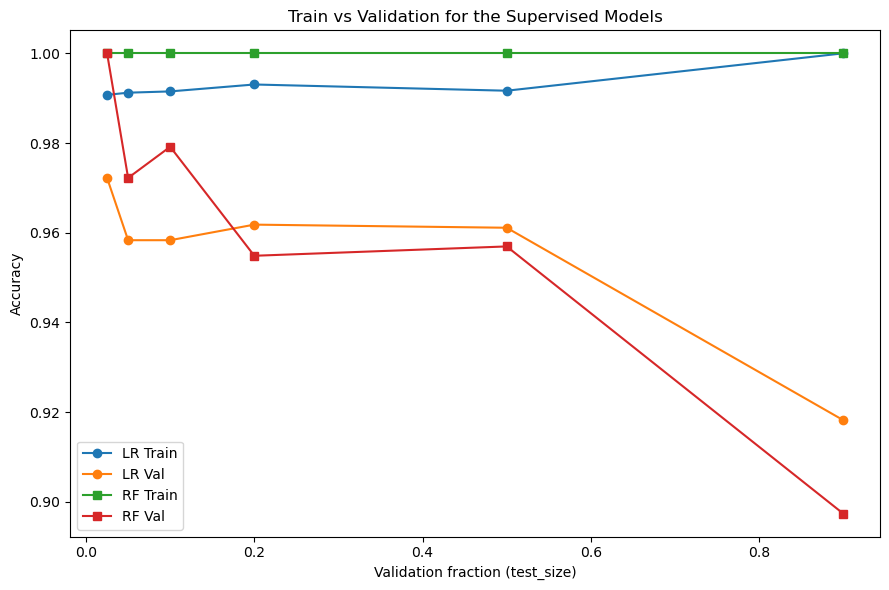

In [79]:
plt.figure(figsize=(9, 6))
plt.plot(valsize_df["test_size"], valsize_df["lr_train_acc"], marker="o", label="LR Train")
plt.plot(valsize_df["test_size"], valsize_df["lr_val_acc"], marker="o", label="LR Val")
plt.plot(valsize_df["test_size"], valsize_df["rf_train_acc"], marker="s", label="RF Train")
plt.plot(valsize_df["test_size"], valsize_df["rf_val_acc"], marker="s", label="RF Val")
plt.xlabel("Validation fraction (test_size)")
plt.ylabel("Accuracy")
plt.title("Train vs Validation for the Supervised Models")
plt.legend()
plt.tight_layout()
plt.show()

#### Comparison of Validation Accuracies (Supervised vs. Matrix Factorization)

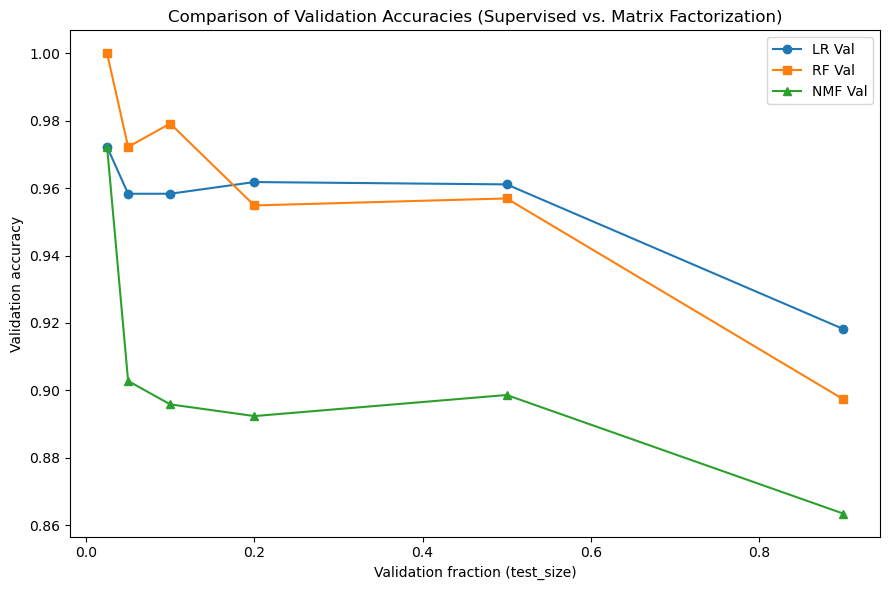

In [80]:
plt.figure(figsize=(9, 6))
plt.plot(valsize_df["test_size"], valsize_df["lr_val_acc"], "o-", label="LR Val")
plt.plot(valsize_df["test_size"], valsize_df["rf_val_acc"], "s-", label="RF Val")
plt.plot(valsize_df["test_size"], valsize_df["nmf_val_acc"], "^-", label="NMF Val")
plt.xlabel("Validation fraction (test_size)")
plt.ylabel("Validation accuracy")
plt.title("Comparison of Validation Accuracies (Supervised vs. Matrix Factorization)")
plt.legend()
plt.tight_layout()
plt.show()

The above visualization clearly shows that NMF performs worse on the validation set when compared to Logistic Regression and Random Forest. Nevertheless, it's performance isn't poor. Given that all validation accuracies decrease as the validation split increases, it appears that all models exhibit characteristics of overfitting on the training data when the validation split is too large. 

#### Comparison of Test Accuracies: NMF, Logistic Regression, and Random Forest
Lastly, I uploaded all Test predictions (for all models and each validation size) to Kaggle in order to compare the Test Results.

Validation Size: 
- 0.025:
  - NMF: 0.91564
  - Logistic Regression: 0.97687
  - Random Forest: 0.95782
- 0.05:
  - NMF: 0.92244
  - Logistic Regression: 0.97823
  - Random Forest: 0.96054
- 0.1:
  - NMF: 0.91020
  - Logistic Regression: 0.97414
  - Random Forest: 0.95918
- 0.2:
  - NMF: 0.91700
  - Logistic Regression: 0.97278
  - Random Forest: 0.95646
- 0.5:
  - NMF: 0.91564
  - Logistic Regression: 0.96054
  - Random Forest: 0.94829
- 0.9:
  - NMF: 0.87210
  - Logistic Regression: 0.91292
  - Random Forest: 0.89115

#### Plot of the Results from previous cell: 

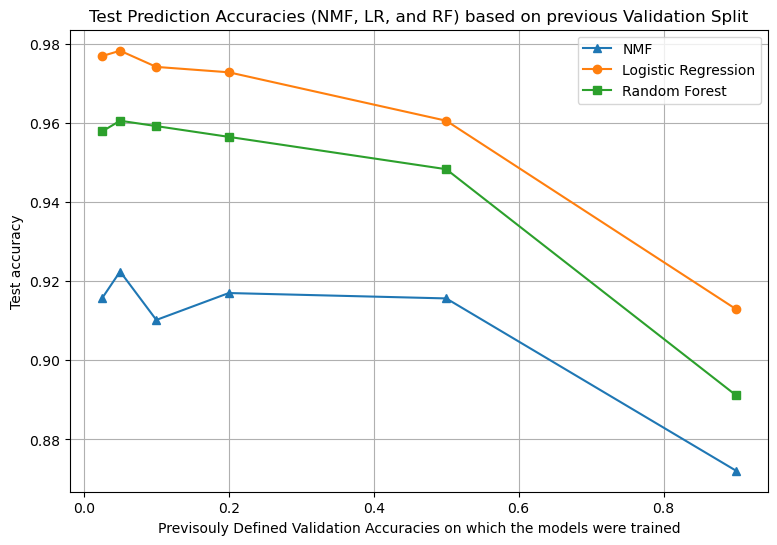

In [84]:
test_sizes = [0.025, 0.05, 0.1, 0.2, 0.5, 0.9]
acc_nmf = [0.91564, 0.92244, 0.91020, 0.91700, 0.91564, 0.87210]
acc_lr  = [0.97687, 0.97823, 0.97414, 0.97278, 0.96054, 0.91292]
acc_rf  = [0.95782, 0.96054, 0.95918, 0.95646, 0.94829, 0.89115]

plt.figure(figsize=(9, 6))
plt.plot(test_sizes, acc_nmf, marker="^", label="NMF")
plt.plot(test_sizes, acc_lr,  marker="o", label="Logistic Regression")
plt.plot(test_sizes, acc_rf,  marker="s", label="Random Forest")
plt.xlabel("Previsouly Defined Validation Accuracies on which the models were trained")
plt.ylabel("Test accuracy")
plt.title("Test Prediction Accuracies (NMF, LR, and RF) based on previous Validation Split")
plt.legend()
plt.grid(True)
plt.show()

## Discussion

In all cases the predictions on the test data have proven to be quite accurate after uploading to kaggle. This suggests that overfitting was not an issue. Yet this could be experimentally verified in a downstream analysis. The unsupervised approach performed slightly worse than both supervised learning approaches, yet still performed well, indicating that unsupervised models are capable at predicting labels when ground truths exist. Otherwise the clusters would need to be reviewed by domain experts. 

The best accuracy score on test was achieved by Logistic Regression with an initial train/val split of 5% and 97.82% accuracy. NMF achieved a maximum score of 92.11%, indicating the supervised outperformed unsupervised.

Generally the following statements hold true: 
- Logistic Regression is more data-efficient
  - It generalizes better with less training data -> as can be seen by the above list
  - Works better in sparse, high-dimensional Tf-IDF spaces
- Random Forest:
  - Generally needs more data to learn meaningful splits
  - May suffer from overfitting in spare settings by trees memorizing training samples -> this would lead to overfittng. This was not an issue in this exploration.
- NMF:
  - Gives stable (but lower) accuracy.

# Literature

- Eskandar, S. (2023, April 26). Exploring feature extraction techniques for Natural Language Processing. Medium. https://medium.com/@eskandar.sahel/exploring-feature-extraction-techniques-for-natural-language-processing-46052ee6514
- Ph.D., J. M., & Kavlakoglu, E. (2025, April 17). What are stemming and lemmatization?. IBM. https://www.ibm.com/think/topics/stemming-lemmatization
- GeeksforGeeks. (2025, May 20). Non-negative matrix factorization. https://www.geeksforgeeks.org/non-negative-matrix-factorization/ 